In [44]:
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs
from utils.plot_utils import shiftedColorMap, template_reorder
from open_ephys.analysis import Session##
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from spikeinterface.core.sorting_tools import random_spikes_selection
import pickle
import datetime
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
from tqdm import tqdm
%matplotlib inline

In [140]:
session = 'behavior_751004_2024-12-23_14-20-03'
data_type = 'curated'
target = 'soma'
load_sorting_analyzer = True

In [46]:
# opto info
session_dir = session_dirs(session)
opto_df = pd.read_csv(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_session_{target}.csv'), index_col=0)
with open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_info_{target}.json')) as f:
    opto_info = json.load(f)
powers = opto_info['powers']
sites = opto_info['sites']
num_pulses = opto_info['num_pulses']
duration = opto_info['durations']
pulse_offset = np.array([1/freq for freq in opto_info['freqs']])
total_duration = (pulse_offset) * num_pulses
session_rec = Session(session_dir['session_dir'])
recording = session_rec.recordnodes[0].recordings[0]
timestamps = recording.continuous[0].timestamps
laser_onset_samples = np.searchsorted(timestamps, opto_df['time'].values)
opto_df['laser_onset_samples'] = laser_onset_samples

In [47]:
# recording info
sorting = si.load_extractor(session_dir[f'curated_dir_{data_type}'])
max_spikes_per_unit_spontaneous = 500
spike_vector = sorting.to_spike_vector()
unit_ids = sorting.unit_ids
num_units = len(sorting.unit_ids)
print(f"Total {len(sorting.unit_ids)} units")
max_spikes_per_unit_spontaneous = 500

Total 177 units


In [72]:
# Spike indices
spike_indices = spike_vector["sample_index"]

response_window = opto_info['resp_win']+0.005 # to take care of potential late responses
response_window_samples = int(response_window * sorting.sampling_frequency)

num_cases = len(opto_info['powers']) * len(opto_info['sites']) * len(opto_info['durations'])

unit_index_offset = num_units
all_unit_ids = [f"{u} spont_pre" for u in unit_ids]
all_unit_ids += [f"{u} spont_post" for u in unit_ids]

all_spikes_in_responses = []
spike_indices_removed = []
conditions = ['powers', 'sites', 'durations', 'pre_post']

for power_ind, curr_power in enumerate(opto_info['powers']):
    for site_ind, curr_site in enumerate(opto_info['sites']):  
        for curr_pre_post_ind, curr_pre_post in enumerate(opto_info['pre_post']):                                                           
            for duration_ind, curr_duration in enumerate(opto_info['durations']):
                spikes_in_response = []
                onset_offset_indices = []
                if len(opto_df.query('site == @curr_site and power == @curr_power and duration == @curr_duration and pre_post == @curr_pre_post')) > 0:
                    for freq_ind, curr_freq in enumerate(opto_info['freqs']):
                        for num_pulse_ind, curr_num_pulses in enumerate(opto_info['num_pulses']):
                            onset_samples = opto_df.query(
                                'site == @curr_site and power == @curr_power and duration == @curr_duration and freq == @curr_freq and num_pulses == @curr_num_pulses and pre_post == @curr_pre_post'
                                )['laser_onset_samples'].values
                            if len(onset_samples) == 0:
                                continue
                            pulse_offset = 1/curr_freq * sorting.sampling_frequency
                            pulse_offset_samples = int(pulse_offset * sorting.sampling_frequency)
                            for pulse_ind in range(curr_num_pulses):
                                for onset_sample in onset_samples:
                                    # response window
                                    onset_response = onset_sample + pulse_ind * pulse_offset_samples
                                    onset_offset_indices.append(onset_response)
                                    offset_response = onset_response + response_window_samples
                                    onset_offset_indices.append(offset_response)
                            start_stop_indices = np.searchsorted(spike_indices, np.array(onset_offset_indices))
                            for i, (start, stop) in enumerate(zip(start_stop_indices[::2], start_stop_indices[1::2])):
                                sv = spike_vector[start:stop]
                                if len(sv) > 0:
                                    spike_indices_removed.append(np.arange(start, stop))
                                sv_copy = sv.copy()
                                sv_copy["unit_index"] = sv_copy["unit_index"] + unit_index_offset + num_units
                                spikes_in_response.append(sv_copy)
                                # num_cases += 1
                    
                    spikes_in_response = np.concatenate(spikes_in_response)
                    print('# of responding units: ', len(np.unique(spikes_in_response['unit_index'])))
                    unit_index_offset += num_units
                    all_spikes_in_responses.append(spikes_in_response)
                    new_unit_ids = [f"{u} emission_location:{curr_site}, power:{curr_power}, duration:{curr_duration}, freq:{curr_freq}, pre_post:{curr_pre_post}" for u in unit_ids]
                    print(f"emission_location:{curr_site}, power:{curr_power}, duration:{curr_duration}, freq:{curr_freq}, pre_post:{curr_pre_post}")
                    all_unit_ids += new_unit_ids
                            



            
all_spikes_in_responses = np.concatenate(all_spikes_in_responses)
spike_indices_removed = np.concatenate(spike_indices_removed)
all_spikes_not_in_responses = np.delete(spike_vector, spike_indices_removed)
all_spikes_not_in_responses_pre = all_spikes_not_in_responses[all_spikes_not_in_responses["sample_index"] < (opto_df.query('pre_post == "pre"')['laser_onset_samples'].max() + 5 * 60 * sorting.sampling_frequency)]
all_spikes_not_in_responses_post = all_spikes_not_in_responses[all_spikes_not_in_responses["sample_index"] > (opto_df.query('pre_post == "post"')['laser_onset_samples'].min() - 5 * 60 * sorting.sampling_frequency)]
# select random spontaneous spikes for each unit divided by first and second half of the session
sorting_no_responses_pre = si.NumpySorting(
    all_spikes_not_in_responses_pre, 
    unit_ids=[f'{unit_id}_pre' for unit_id in unit_ids], 
    sampling_frequency=sorting.sampling_frequency
)
random_spike_indices = random_spikes_selection(sorting_no_responses_pre, method="uniform",
                                               max_spikes_per_unit=max_spikes_per_unit_spontaneous)
selected_spikes_no_responses_pre = all_spikes_not_in_responses_pre[random_spike_indices]



sorting_no_responses_post = si.NumpySorting(
    all_spikes_not_in_responses_post, 
    unit_ids=[f'{unit_id}_post' for unit_id in unit_ids], 
    sampling_frequency=sorting.sampling_frequency
)
random_spike_indices = random_spikes_selection(sorting_no_responses_post, method="uniform",
                                               max_spikes_per_unit=max_spikes_per_unit_spontaneous)
selected_spikes_no_responses_post = all_spikes_not_in_responses_post[random_spike_indices]
selected_spikes_no_responses_post_copy = selected_spikes_no_responses_post.copy()
selected_spikes_no_responses_post_copy["unit_index"] = selected_spikes_no_responses_post["unit_index"] + num_units



all_spikes = np.concatenate([selected_spikes_no_responses_pre, selected_spikes_no_responses_post_copy, all_spikes_in_responses])

# sort by segment+index
all_spikes = all_spikes[
    np.lexsort((all_spikes["sample_index"], all_spikes["segment_index"]))
]

sorting_all = si.NumpySorting(
    all_spikes, 
    unit_ids=all_unit_ids, 
    sampling_frequency=sorting.sampling_frequency
)

# of responding units:  66
emission_location:surface_LC, power:10, duration:4, freq:5, pre_post:post
# of responding units:  88
emission_location:surface_LC, power:20, duration:4, freq:5, pre_post:post
# of responding units:  84
emission_location:surface_LC, power:30, duration:4, freq:5, pre_post:post
# of responding units:  116
emission_location:surface_LC, power:30, duration:4, freq:5, pre_post:pre
# of responding units:  84
emission_location:surface_LC, power:40, duration:4, freq:5, pre_post:post
# of responding units:  90
emission_location:surface_LC, power:50, duration:4, freq:5, pre_post:post


In [73]:
print("original:", len(spike_vector))
print("sampled:", len(sorting_all.to_spike_vector()))

original: 6634213
sampled: 130468


In [74]:
def load_and_preprocess_recording(session_folder, stream_name):
    ephys_path = os.path.dirname(session_folder)
    compressed_folder = os.path.join(ephys_path, 'ecephys_compressed')
    recording_zarr = [os.path.join(compressed_folder, f) for f in os.listdir(compressed_folder) if stream_name in f][0]
    recording = si.read_zarr(recording_zarr)
    # preprocess
    recording_processed = spre.phase_shift(recording)
    recording_processed = spre.highpass_filter(recording_processed)    
    recording_processed = spre.common_reference(recording_processed)
    return recording_processed

In [75]:
# filter good channels
recording_processed = load_and_preprocess_recording(session_dir['session_dir'], 'ProbeA')
we = si.load_sorting_analyzer_or_waveforms(session_dir[f'postprocessed_dir_{data_type}'])
good_channel_ids = recording_processed.channel_ids[
    np.in1d(recording_processed.channel_ids, we.channel_ids)
]

recording_processed_good = recording_processed.select_channels(good_channel_ids)
print(f"Num good channels: {recording_processed_good.get_num_channels()}")

Num good channels: 379


In [77]:
num_cases = len(sorting_all.unit_ids) // num_units - 2
sparsity_mask_all = np.tile(we.sparsity.mask, (num_cases + 2, 1))
sparsity_all = si.ChannelSparsity(
    sparsity_mask_all,
    unit_ids=sorting_all.unit_ids,
    channel_ids=recording_processed_good.channel_ids
)
si.set_global_job_kwargs(n_jobs=-1, progress_bar=True)

In [78]:
si.set_global_job_kwargs(n_jobs=-1, progress_bar=True)

In [79]:
# create analyzer
analyzer_all = si.create_sorting_analyzer(
    # sorting_all.select_units(ROI_unit_ids),
    sorting_all,
    recording_processed_good,
    sparsity=sparsity_all
)

In [80]:
min_spikes_per_unit = 5
keep_unit_ids = []
count_spikes = sorting_all.count_num_spikes_per_unit()
for unit_id, count in count_spikes.items():
    if count >= min_spikes_per_unit:
        keep_unit_ids.append(unit_id)

analyzer = analyzer_all.select_units(keep_unit_ids)
print(f"Number of units with at least {min_spikes_per_unit} spikes: {len(analyzer.unit_ids)}")

['0 spont_pre', '1 spont_pre', '2 spont_pre', '3 spont_pre', '4 spont_pre', '5 spont_pre', '6 spont_pre', '7 spont_pre', '8 spont_pre', '9 spont_pre', '10 spont_pre', '15 spont_pre', '16 spont_pre', '17 spont_pre', '18 spont_pre', '19 spont_pre', '21 spont_pre', '22 spont_pre', '26 spont_pre', '27 spont_pre', '28 spont_pre', '29 spont_pre', '30 spont_pre', '31 spont_pre', '32 spont_pre', '33 spont_pre', '34 spont_pre', '35 spont_pre', '36 spont_pre', '37 spont_pre', '39 spont_pre', '41 spont_pre', '42 spont_pre', '43 spont_pre', '44 spont_pre', '45 spont_pre', '46 spont_pre', '47 spont_pre', '48 spont_pre', '50 spont_pre', '51 spont_pre', '52 spont_pre', '58 spont_pre', '59 spont_pre', '60 spont_pre', '61 spont_pre', '62 spont_pre', '63 spont_pre', '64 spont_pre', '65 spont_pre', '66 spont_pre', '67 spont_pre', '68 spont_pre', '69 spont_pre', '70 spont_pre', '71 spont_pre', '72 spont_pre', '73 spont_pre', '74 spont_pre', '75 spont_pre', '76 spont_pre', '77 spont_pre', '78 spont_pre', '

In [82]:
_ = analyzer.compute("random_spikes", method="all")
_ = analyzer.compute(["waveforms", "templates"])
waveform_zarr_folder = f'{session_dir[f"opto_dir_{data_type}"]}/opto_waveforms.zarr'
analyzer_saved_zarr = analyzer.save_as(format='zarr', folder = waveform_zarr_folder)

compute_waveforms:   0%|          | 0/6698 [00:00<?, ?it/s]

In [85]:
analyzer_saved_zarr = analyzer.save_as(format='zarr', folder = f'{session_dir[f"opto_dir_{data_type}"]}/opto_waveforms.zarr')

In [6]:
if load_sorting_analyzer:
    # Load
    # analyzer_loaded = si.load_sorting_analyzer(f'{results_folder}/analyzer_saved')
    waveform_zarr_folder = f'{session_dir[f'opto_dir_{data_type}']}/opto_waveforms.zarr'
    analyzer = si.load_sorting_analyzer(waveform_zarr_folder)
    print(analyzer)

SortingAnalyzer: 379 channels - 451 units - 1 segments - zarr - sparse - has recording
Loaded 3 extensions: random_spikes, templates, waveforms


In [135]:
conditions = ['power', 'site', 'duration', 'pre_post']
columns = ['unit_id'] + conditions + ['template', 'peak_channel', 'peak_waveform', 'spont', 'count']
waveform_metrics = pd.DataFrame(columns=columns)

template_ext = analyzer.get_extension("templates")
extreme_channel_indices = si.get_template_extremum_channel(analyzer, mode = "at_index", outputs = "index")
extreme_channels = si.get_template_extremum_channel(analyzer) 

for ind_id, unit_id in enumerate(analyzer.unit_ids):
    print(unit_id)
    unit_id_name, case = unit_id.split(" ", 1)
    # print(unit_id_name, case)
    unit_template = template_ext.get_unit_template(unit_id)       
    peak_waveform = unit_template[:,extreme_channel_indices[unit_id]]
    # plt.figure()
    # plt.plot(list(unit_waveform[:,extreme_channel_indices["14 spont"]]))
    # plt.show()

    new_row = dict(unit_id=unit_id_name, template=unit_template, peak_channel=extreme_channels[unit_id], peak_waveform=peak_waveform, count=len(analyzer.sorting.get_unit_spike_train(unit_id)))
    if "spont" in case:
        pre_post = case.split("_")[1]                
        new_row["spont"] = 1
        new_row["pre_post"] = pre_post
        new_row["power"] = np.nan
        new_row["site"] = np.nan
        new_row["duration"] = np.nan

    else:
        split_strs = case.split(",")
        site_str, power_str, duration_str, freq_str, pre_post_str = split_strs

        site = site_str.split(":")[1]
        power = power_str.split(":")[1]
        duration = duration_str.split(":")[1]
        pre_post = pre_post_str.split(":")[1]
        # site = site_str.split(":")[1]
        new_row["spont"] = 0
        new_row["pre_post"] = pre_post
        new_row["power"] = power
        new_row["site"] = site
        new_row["duration"] = duration
        # new_row["site"] = power
    waveform_metrics = pd.concat([waveform_metrics, pd.DataFrame([new_row])], ignore_index=True)


0 spont_pre
1 spont_pre
2 spont_pre
3 spont_pre
4 spont_pre
5 spont_pre
6 spont_pre
7 spont_pre
8 spont_pre
9 spont_pre
10 spont_pre
15 spont_pre
16 spont_pre
17 spont_pre
18 spont_pre
19 spont_pre
21 spont_pre
22 spont_pre
26 spont_pre
27 spont_pre
28 spont_pre
29 spont_pre
30 spont_pre
31 spont_pre
32 spont_pre
33 spont_pre
34 spont_pre
35 spont_pre
36 spont_pre
37 spont_pre
39 spont_pre
41 spont_pre
42 spont_pre
43 spont_pre
44 spont_pre
45 spont_pre
46 spont_pre
47 spont_pre
48 spont_pre
50 spont_pre
51 spont_pre
52 spont_pre
58 spont_pre
59 spont_pre
60 spont_pre
61 spont_pre
62 spont_pre
63 spont_pre
64 spont_pre
65 spont_pre
66 spont_pre
67 spont_pre
68 spont_pre
69 spont_pre
70 spont_pre
71 spont_pre
72 spont_pre
73 spont_pre
74 spont_pre
75 spont_pre
76 spont_pre
77 spont_pre
78 spont_pre
79 spont_pre
80 spont_pre
81 spont_pre
82 spont_pre
83 spont_pre
84 spont_pre
85 spont_pre
86 spont_pre
87 spont_pre
88 spont_pre
89 spont_pre
90 spont_pre
91 spont_pre
92 spont_pre
93 spont_

In [141]:
# calculate correlation and Euclidean distance, normalized by power
waveform_metrics['unit_id'].unique()
waveform_metrics['euclidean_norm'] = np.nan
waveform_metrics['correlation'] = np.nan
sparsity = analyzer.sparsity
all_channels = sparsity.channel_ids
# loop through all rows in the dataframe
for index, row in waveform_metrics.iterrows():
    # get the template and peak waveform for the current row
    if row['spont'] == 1:
        continue
    else:
        # 
        template = row['template']
        peak_channel = row['peak_channel']
        unit_id = row['unit_id']
        pre_post = row['pre_post']

        spont_unit = waveform_metrics.query("spont == 1 and unit_id == @unit_id and pre_post == @pre_post")
        if len(spont_unit) == 0:
            template_spont = np.nan
            waveform_spont = np.nan
            channel_spont = np.nan
        else:
            template_spont = spont_unit['template'].values[0]
            peak_waveform_spont = spont_unit['peak_waveform'].values[0]
            peak_channel_spont = spont_unit['peak_channel'].values[0]
        
        peak_channel_ind = np.argmin(np.min(template_spont, 0))
        peak_waveform_resp = template[:, peak_channel_ind]
        waveform_metrics.at[index, 'peak_waveform'] = peak_waveform_resp
        peak_samp_ind = np.argmin(peak_waveform_spont)

        # correlation 
        correlation = np.corrcoef(peak_waveform_resp.reshape(-1), peak_waveform_spont.reshape(-1))[0, 1]
        waveform_metrics.at[index, 'correlation'] = correlation
        # euclidean distance

        euc_dist = np.sqrt(np.linalg.norm(
            peak_waveform_resp[np.max(np.array([peak_samp_ind-10, 0])): np.min(np.array([peak_samp_ind+20, len(peak_waveform_spont)]))]
            - peak_waveform_spont[np.max(np.array([peak_samp_ind-10, 0])): np.min(np.array([peak_samp_ind+20, len(peak_waveform_spont)]))]))
        # energy
        energy = np.sqrt(np.sum(np.square(peak_waveform_spont[np.max(np.array([peak_samp_ind-10, 0])): np.min(np.array([peak_samp_ind+20, len(peak_waveform_spont)]))])))
        euc_dist_norm = euc_dist / energy
        waveform_metrics.at[index, 'euclidean_norm'] = euc_dist_norm

waveform_metrics.to_csv(f"{session_dir[f'opto_dir_{data_type}']}/{session}_opto_waveform_metrics.csv", index=False)
print(f"Saved waveform metrics to {session_dir[f'opto_dir_{data_type}']}/{session}_opto_waveform_metrics.csv")


Saved waveform metrics to /root/capsule/scratch/751004/behavior_751004_2024-12-23_14-20-03/ephys/curated/processed/behavior_751004_2024-12-23_14-20-03_opto_waveform_metrics.csv


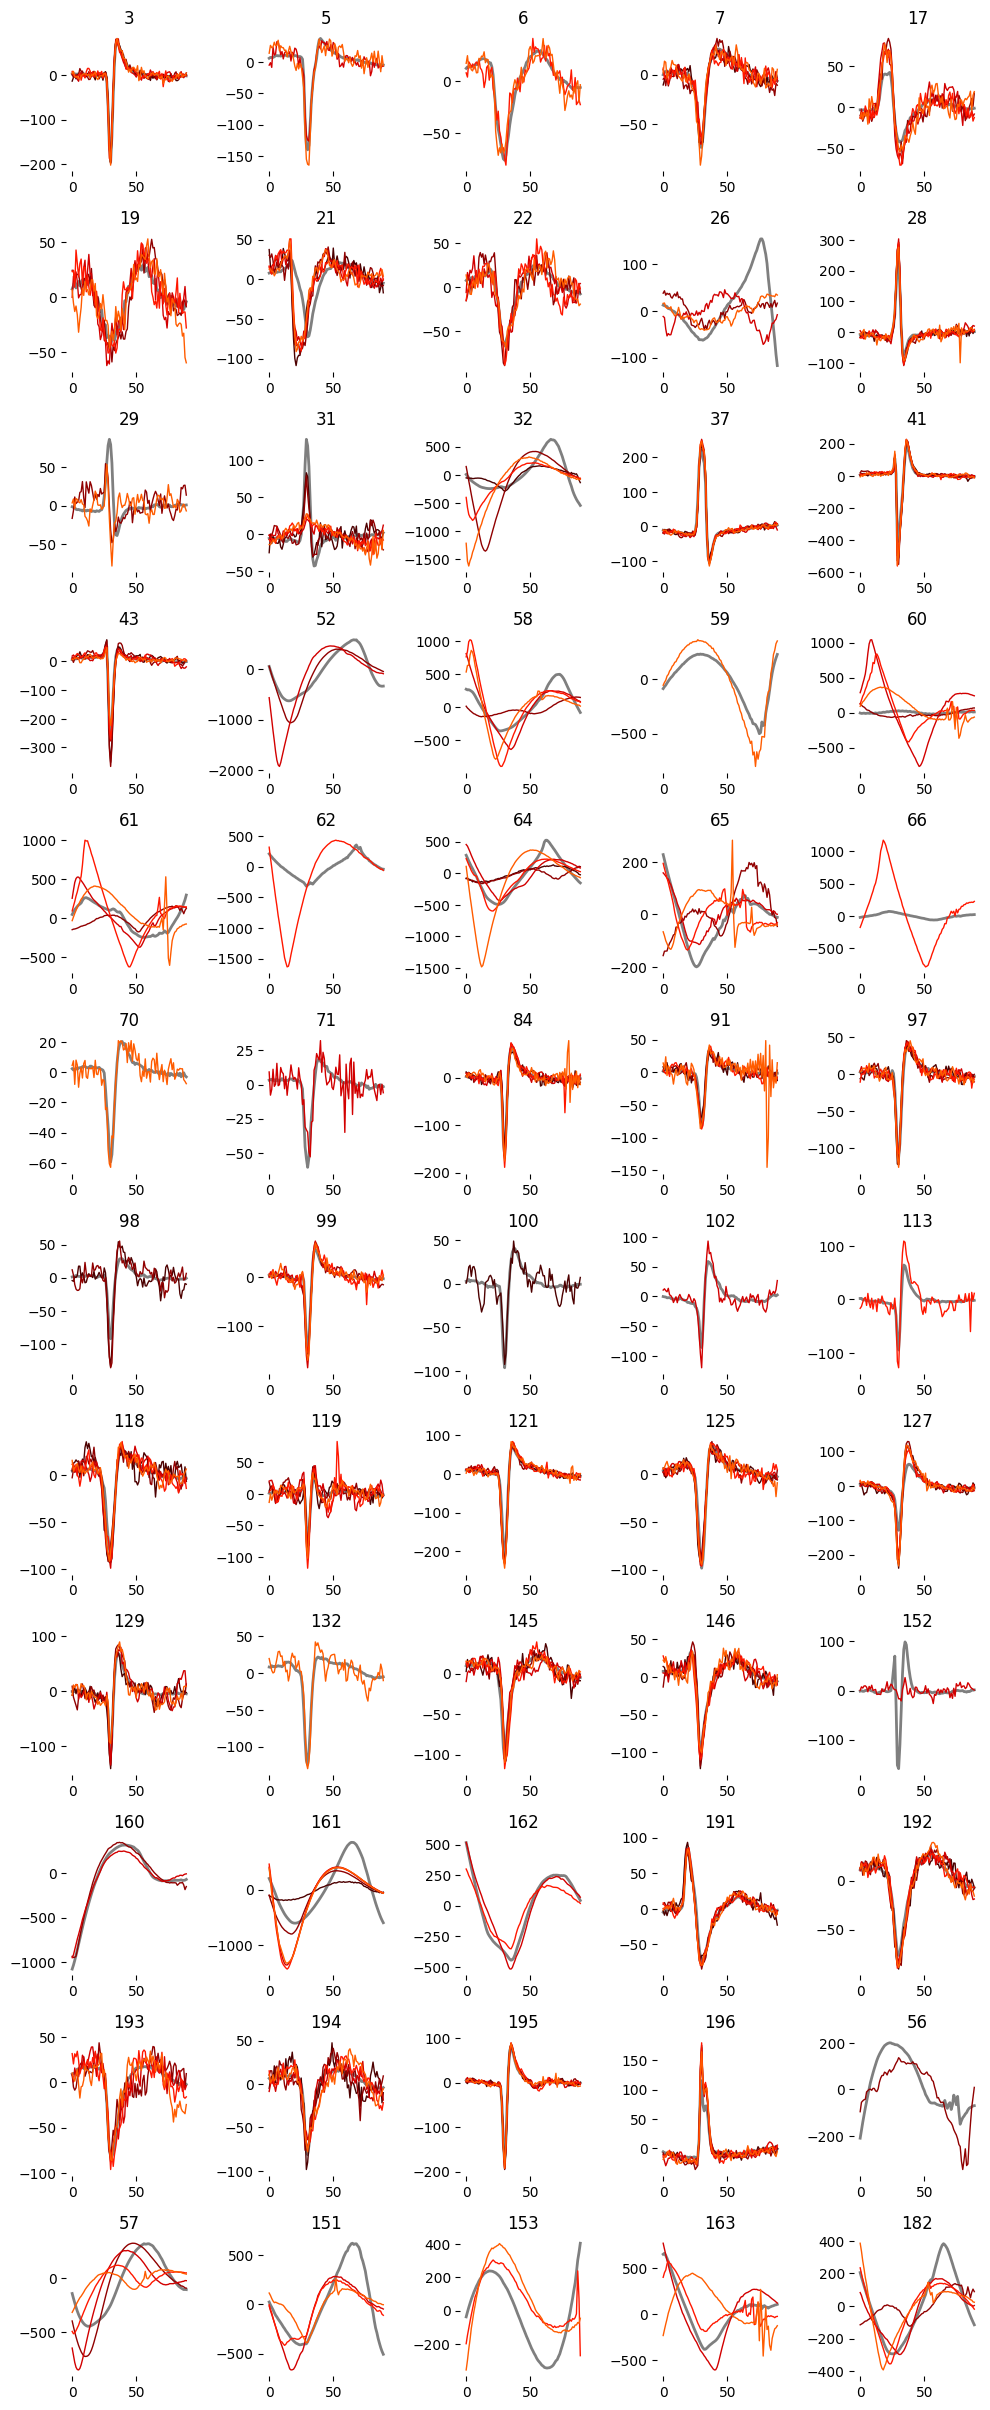

In [154]:
unit_ids = waveform_metrics['unit_id'].unique()
gs = gridspec.GridSpec(20, 5)
fig = plt.figure(figsize=(10, 40))
count = 0
for unit_id in unit_ids:
    spont_post = waveform_metrics.query('spont == 1 and unit_id == @unit_id and pre_post == "post"')
    spont_pre = waveform_metrics.query('spont == 1 and unit_id == @unit_id and pre_post == "pre"')
    if len(spont_post) > 0:
        wf_spont = spont_post['peak_waveform'].values[0]
    elif len(spont_pre) > 0:
        wf_spont = spont_pre['peak_waveform'].values[0]
    else:
        continue

    resp = waveform_metrics.query('spont == 0 and unit_id == @unit_id and pre_post == "post"')
    if len(resp) > 0:
        wf_resp = resp['peak_waveform'].values
        wf_powers = resp['power'].values
        ax = fig.add_subplot(gs[count])
        ax.plot(wf_spont, color='k', linewidth=2, alpha = 0.5)
        for wf, power in zip(wf_resp, wf_powers):
            ax.plot(wf, color=colormaps['hot'](int(power)/100), linewidth=1)
        ax.set_frame_on(False)
        count = count + 1
        ax.set_title(unit_id)
    else:
        continue

plt.tight_layout()
fig.savefig(fname=f"{session_dir[f'opto_dir_{data_type}']}/{session}_opto_waveforms.pdf")
    